In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)
severe_frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='severe_frost_days_count', index_col=0)


According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the Ashenfelter experiment

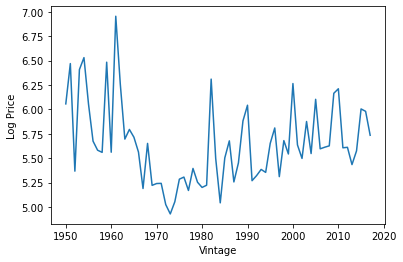

In [10]:
y = prices.set_index('Vintage', drop=True)
y['Log Price'] = np.log(y['Price'])
y=y[['Log Price']]
sns.lineplot(data=y['Log Price'])
plt.show()

In [11]:
X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12

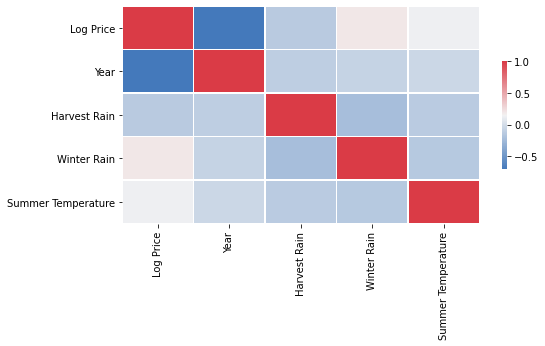

In [12]:
oldest_vintage=1950
newest_vintage=1980
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)
corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

## Building the model

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
    
    
print('Model Score: ',r2_score(model.predict(X_ex),y_ex))

Year -0.038896821882376316
Harvest Rain -0.0012086551317580002
Winter Rain 0.0005620921563760735
Summer Temperature 0.08181432063246365
Model Score:  0.19603008278375966


This score is quite good, but not as impressive as in the original Ashenfelter experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this models coefficients have changed over time.

In [14]:
from sklearn.preprocessing import StandardScaler

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1996))
    scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 20

        y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        scores.append(r2_score(model.predict(X_ex),y_ex))
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, scores


#We will need ticks correspoding to our rolling windows for the graphs
labels = [str(i)+'-'+str(i+20) for i in range(1950,1996,5)]

,Year,Harvest Rain,Winter Rain,Summer Temperature
1950,-0.040178,-0.098005,0.059541,0.036516
1951,-0.045905,-0.086523,0.062963,0.096626
1952,-0.047684,-0.086844,0.071826,0.075480
1953,-0.060382,-0.047995,0.081295,0.170079
1954,-0.059346,-0.047835,0.084967,0.186502


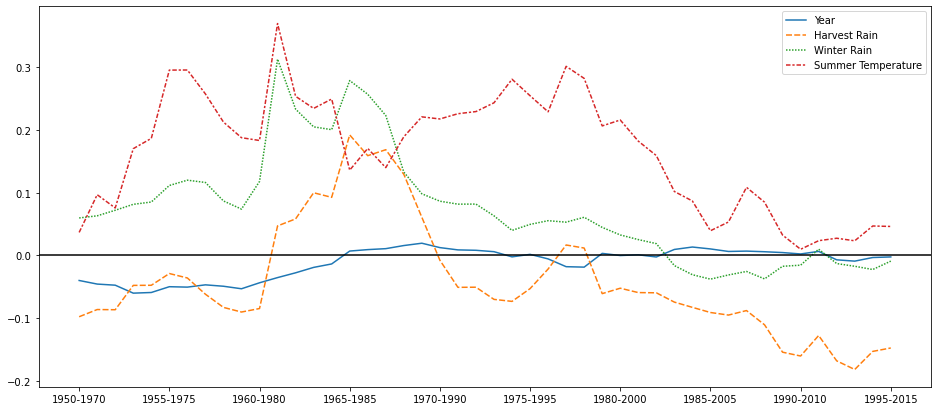

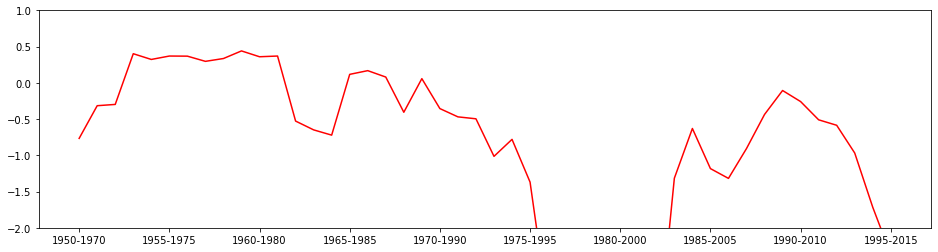

Average score over the whole period:  -0.8530744053735202


In [15]:
coefficients, scores = model_tester(X, y)
plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,46,5),labels=labels)
plt.ylim((-2,1))
plt.plot(0)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Adding new variables

In [34]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

X['Severe Frost Days'] = (severe_frost_days['Sep'].shift(1).fillna(0) + severe_frost_days['Oct'].shift(1).fillna(0) + severe_frost_days['Nov'].shift(1).fillna(0))*3 + severe_frost_days['Dec'].shift(1).fillna(0)*2 + severe_frost_days['Jan'] + severe_frost_days['Fev'] + severe_frost_days['Mar']*2 + severe_frost_days['Mar']*3

X['Frost Days Prev Fall'] = 2*frost_days['Sep'].shift(1).fillna(0)+ 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0) + frost_days['Dec'].shift(1).fillna(0)

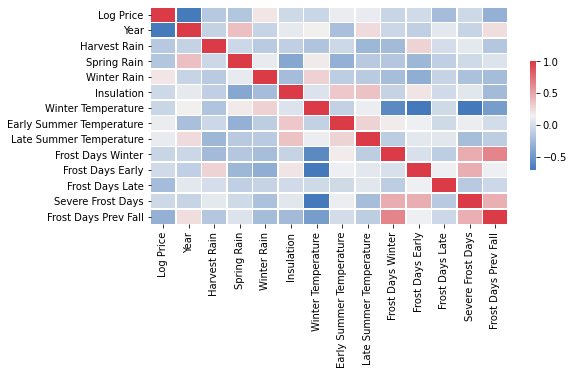

In [35]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Insulation,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Early,Frost Days Late,Severe Frost Days,Frost Days Prev Fall
1950,-0.052114,-0.172239,0.011372,0.001715,0.004332,-0.616308,-0.063069,0.168888,-0.375575,-0.297137,-0.087474,-0.010219,-0.131153
1951,-0.053824,-0.161204,0.023528,0.013024,0.007119,-0.598032,-0.066384,0.197691,-0.358060,-0.280343,-0.079528,0.000201,-0.146825
1952,-0.049120,-0.174902,0.035826,-0.010547,0.026292,-0.548995,-0.067550,0.192594,-0.317670,-0.254458,-0.073482,0.016180,-0.195973
1953,-0.085063,-0.313472,0.146533,0.021709,-0.117667,-0.304908,0.659207,-0.189502,-0.254017,0.008308,0.033070,-0.178578,0.130966
1954,-0.095359,-0.326183,0.145554,0.073625,-0.192372,-0.168164,0.760830,-0.207724,-0.108662,0.133516,0.050666,-0.217395,0.147257


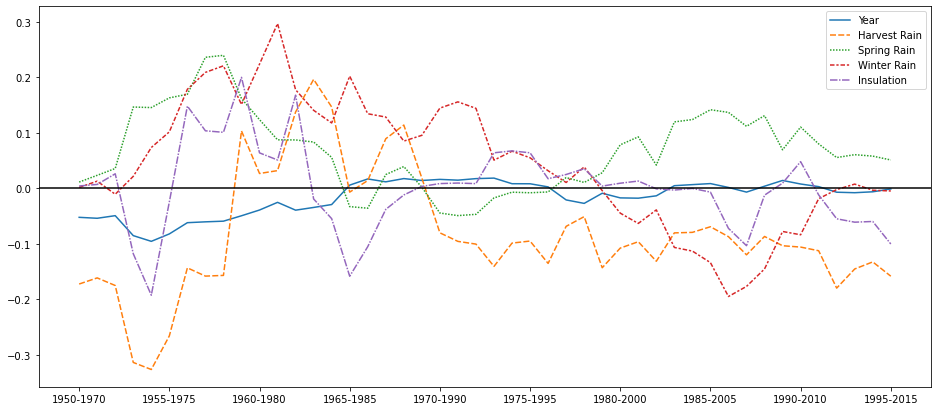

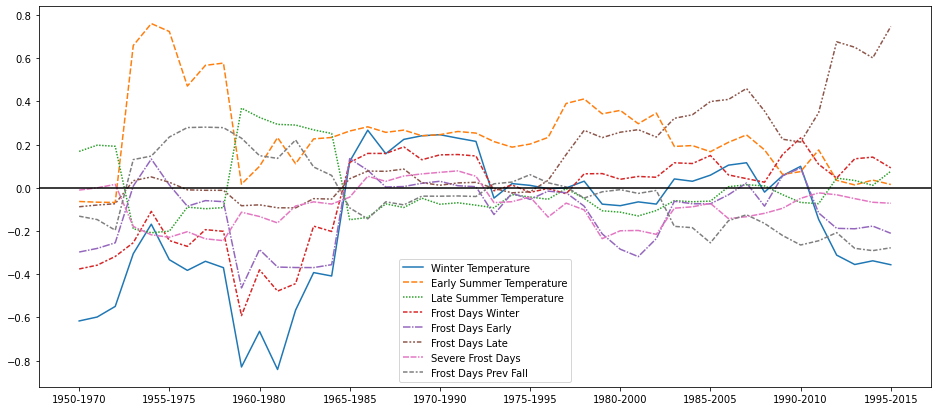

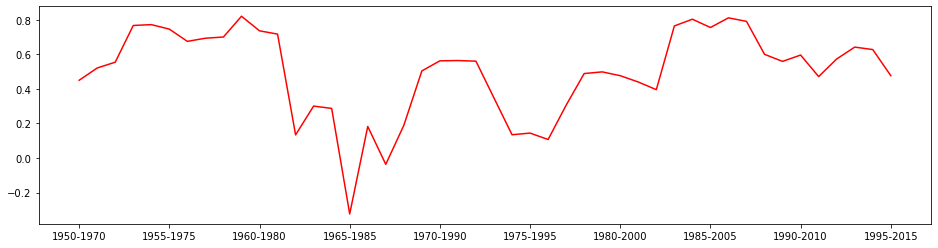

Average score over the whole period:  0.4979829143776143


In [36]:
coefficients, scores = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,46,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [40]:
from sklearn.metrics import r2_score

display(y)
for column in X.columns:
    print(column, ':',r2_score(y.loc[1950:2015, 'Log Price'].values, X.loc[1950:2015, column].values))

,Log Price
Vintage,
1950,6.056394
1951,6.469423
1952,5.367075
1953,6.408163
1954,6.530347
...,...
2015,6.004613
2016,5.980076
2017,5.734958


Harvest Rain : -650093.9470313198
Spring Rain : -116546.83900980931
Winter Rain : -1705539.7031715834
Insulation : -24303076.72023373
Winter Temperature : -17052.637338141994
Early Summer Temperature : -92457.77841614425
Late Summer Temperature : -29274.85794244147
Frost Days Winter : -1611.0604256667611
Frost Days Early : -525.4274594917564
Frost Days Late : -146.49044005391474


# Improved model

In [10]:
X = pd.DataFrame(index = precipitations.index)

X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important

#X['Square Winter Rain'] =  X['Winter Rain']**2

X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2

#X['Square Harvest Rain'] =  X['Harvest Rain']**2



X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])

X['Square Winter Temperature'] = X['Winter Temperature']**2

X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

#X['Square Summer Temperature'] = X['Summer Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])*3+\
                    (temp_maximals['Oct'] + temp_minimals['Oct'])*2


X['Square Harvest Temperature'] = X['Harvest Temperature']**2




#X['Frost Days'] = frost_days['Fev']+2*frost_days['Mar']+ 3*frost_days['Avr']+ 3*(frost_days['Mai'] + frost_days['Jui'])

#X['Square Frost Days'] = X['Frost Days']**2

#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores

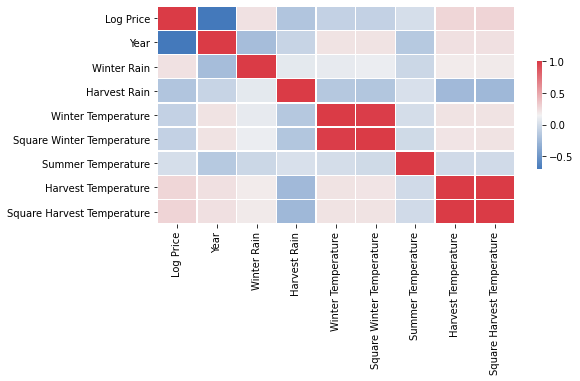

In [11]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.savefig('views/heatmap.png', bbox_inches='tight')
plt.show()

,Year,Winter Rain,Harvest Rain,Winter Temperature,Square Winter Temperature,Summer Temperature,Harvest Temperature,Square Harvest Temperature
1950,-0.059551,-0.028665,-0.002484,-0.084345,0.043909,-0.118125,-2.974749,3.615243
1951,-0.056707,-0.023332,-0.005214,-0.041407,-0.003874,-0.159973,-3.682859,4.338313
1952,-0.055213,-0.023981,-0.010861,-0.142439,0.119319,-0.161676,-4.078904,4.755432
1953,-0.062110,-0.045649,-0.028888,-0.054764,0.005272,-0.003127,-6.246105,6.905850
1954,-0.058901,-0.098702,-0.008075,-0.248579,0.274465,0.021679,-6.411769,7.093299


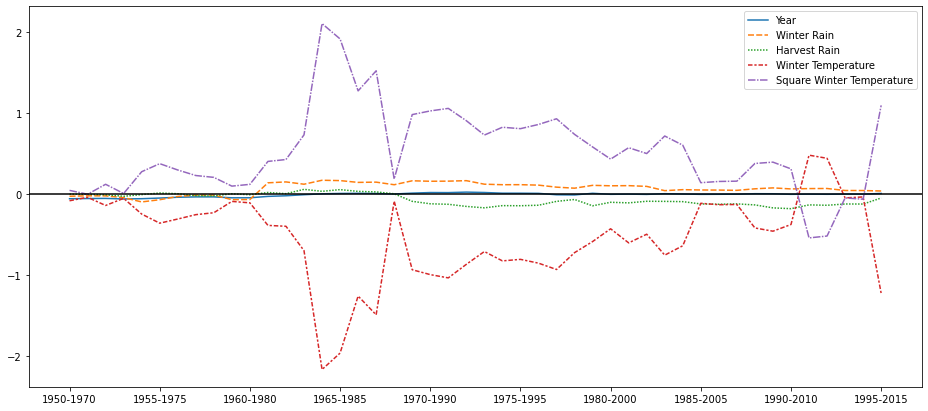

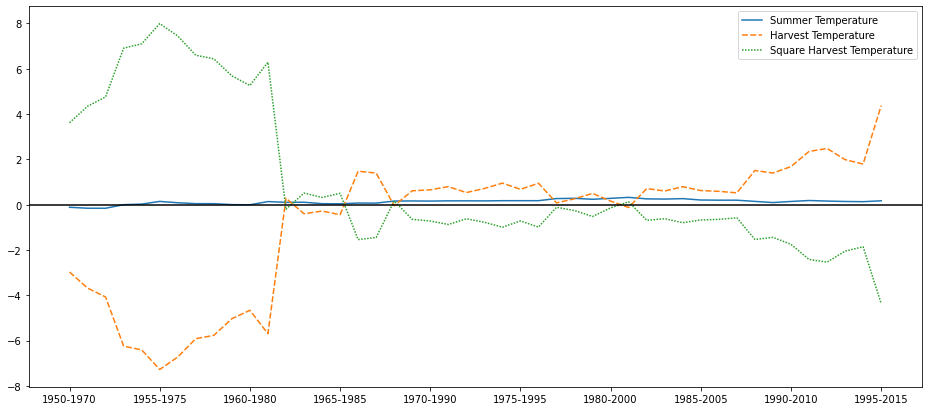

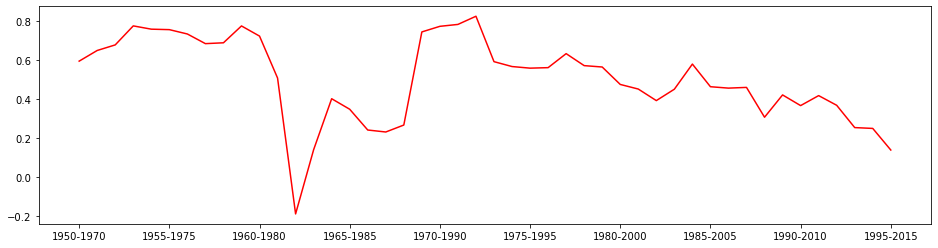

Average score over the whole period:  0.5053573117136062


In [12]:
coefficients, scores = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.xticks(range(0,46,5),labels=labels)
plt.show()
print('Average score over the whole period: ',np.mean(scores))

# Can it predict prices?

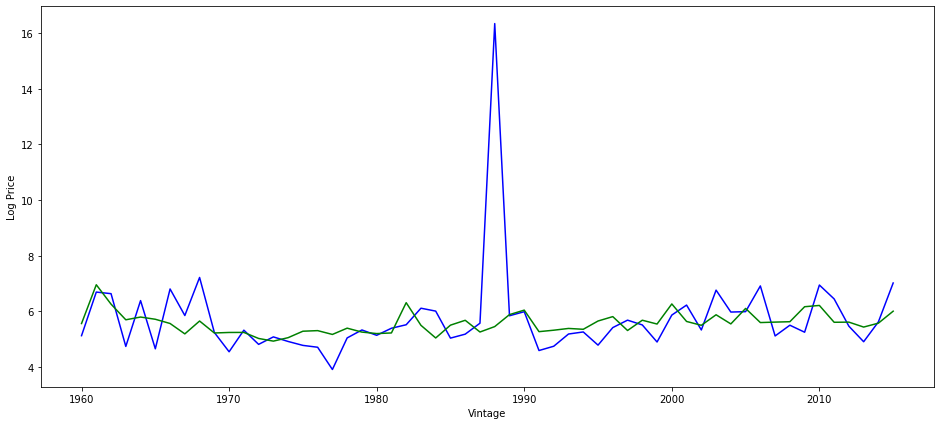

In [68]:
def reg_predict(X,y, window_length):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage - window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()
        model.fit(X_ex,y_ex)

        target = np.array([target_vintage]+X.loc[target_vintage,:].to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 10
plt.figure(figsize=(16,7))
plt.plot(range(1950+window_length,2016), reg_predict(X,y, window_length), color='blue')
sns.lineplot(data=y.loc[1950+window_length:2015,'Log Price'], color='green')
plt.show()

Let us compare the r2 score of our model, regression with a window of width n against the r2 score of a simple model that draws a regression line on the last n prices and simply continues that line to predict the next price.

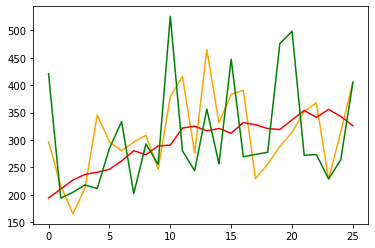

[-2.3450075073671157, -0.5703590083914978, -0.6028129399571327, -0.38768197967616835, -0.2666032947396917, -0.330468441251597, -0.32831633936196813, -0.33116771106165155, -0.1303322137066958, -0.010879199600015266, -0.05029274707129994, 0.09666031079641324, 0.05063269064892384, 0.03522393004795965, 0.016595094073112437, -0.0968035677616852, 0.006308146161686845, 0.08302870275128305, 0.050535286583141326, 0.009981925866179853, 0.04682124399681431, 0.09909078192505316, 0.025958460962042684, 0.0012502307594614015, -0.07201339000364104, -0.07899423032389419, -0.082441338489041, -0.09202823051342479]


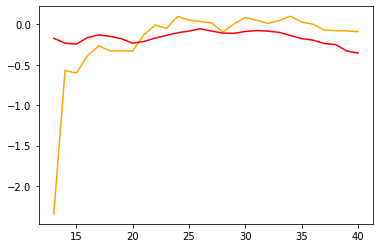

Maximal score:  0.09909078192505316


In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores=[]
other_scores=[]
line_regressor = LinearRegression()

for window_length in range(13,41,1):
    prediction = np.exp(reg_predict(X,y, window_length))
    prediction = np.array(prediction.reshape(1,-1).tolist()[0][-26:]).reshape(1,-1)[0]
    actual_prices = np.exp(y.loc[1990:2015,'Log Price']).values

    line_model_predictions = np.zeros_like(actual_prices)
    
    for vintage in range(1990,2016):
        X_ex = np.array(X.loc[(vintage - window_length):(vintage -1)].index.to_list()).reshape(-1,1)
        y_ex = y.loc[(vintage - window_length):(vintage -1),'Log Price']
        line_regressor.fit(X_ex, y_ex)
        target = np.array([vintage]).reshape(1,-1)
        line_model_predictions[vintage-1990] = line_regressor.predict(target)

    line_model_predictions = np.exp(line_model_predictions)
    if window_length==30:
        plt.plot(prediction, color='orange')
        plt.plot(line_model_predictions, color='red')
        plt.plot(actual_prices, color='green')
        plt.show()
    scores.append(r2_score(actual_prices, prediction))
    other_scores.append(r2_score(actual_prices, line_model_predictions))

print(scores)
plt.plot(range(13,41,1),scores, color='orange')
plt.plot(range(13,41,1),other_scores, color='red')

plt.show()
print('Maximal score: ',max(scores))

According to the results, let us keep a window length of 30.
Now, try to quantify the predictive performance of this algo across the last 50 years.

36


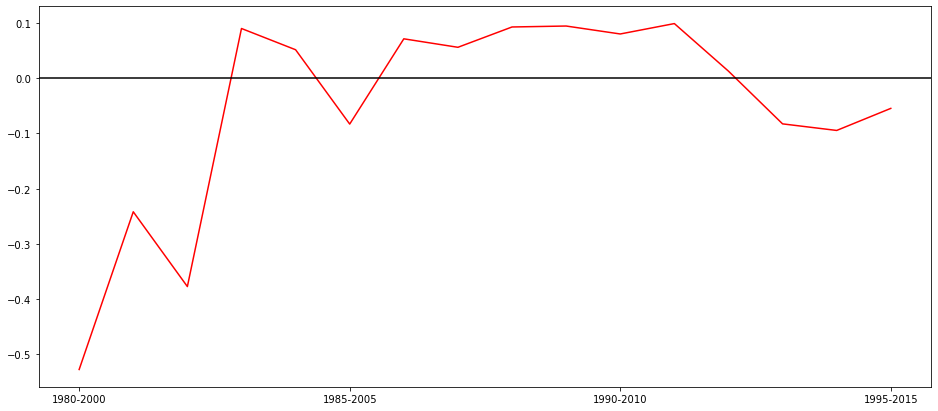

36 -0.15590144707037568


In [82]:
window_length=30

predictions = np.exp(reg_predict(X,y, window_length))
actual_prices = np.exp(y.loc[1980:2015,'Log Price']).values
print(len(predictions))
r2_scores=[]
for i in range(16):
    r2_scores.append(r2_score(actual_prices[i:(i+20)],predictions[i:(i+20)]))

plt.figure(figsize=(16,7))

labels = [str(i)+'-'+str(i+20) for i in range(1980,1996,5)]
plt.xticks(range(0,16,5),labels=labels)

sns.lineplot(x=range(16), y=r2_scores, color='red').axhline(0., color='black')
plt.show()

print(len(predictions), r2_score(actual_prices, predictions))

# Appendix: Trying PCA

In [ ]:
X = pd.concat([precipitations, insulation, temp_maximals, temp_minimals, frost_days], axis=1)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

In [ ]:
coefficients, scores = model_tester(X2,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

PCA doesn't give good enough results, provided that it makes us lose track of the variables' meanings. We will not use it.

# Appendix: quadratic effects